<a href="https://colab.research.google.com/github/lars-x/20778-Analyzing-Data-with-Power-BI/blob/master/Lab3_Highway_DQN_rlagents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab3 is based on highway-env https://github.com/eleurent/highway-env. In 
envs/highway_env.py, the vehicle is rewarded for reaching a high speed, staying on the rightmost lanes and avoiding collisions for in highway driving (highway-env). Your task is to add an additional term to penalize changing lanes. (Ideally we should penalize changing lanes to the left more than changing to the right, but this is a simplified exercise.) Please refer to envs/roundabout_env for reference.

Steps:

1) Fork the highway-env repository to your own GitHub account, and modify highway_env.py. (if you are not familiar with GitHub, I recommend installing GitHub Desktop https://desktop.github.com.)

2) Replace 
!pip install highway-env 
with path to your own repository:
!pip install git+https://github.com/USERNAME/highway-env

3) Train your agent for different values of lane_change_reward, and different environments with varying complexity, starting from the simplest:

env.config["lane_change_reward"] = 0

env.config["vehicles_count"] = 0

env.config["lanes_count"] = 2

env.config["initial_lane_id"] = 0

In this simple environment, during testing the vehicle should switch to the right lane quickly and stay in the right lane. (It is possible for it to stay in the left lane during testing if your training num_episodes is too small, since the agent may not have had a chance to try the lane change action during training.)
Try different values of lane_change_reward (e.g., -0.1, -1, -10, etc. note that it must be negative), and different numbers of vehicles/lanes. Make lane_change_reward very negative until you observe that the vehicle prefers *collision* to *lane change to avoid collision*. Submit your IPython Notebook, and a short report (or text blocks within the Notebook) describing the different configurations you have tried, and your observations for each config, including two configs that differ only in the lane_change_reward, one with no or rare collisions, one with frequent collisions.

Notes: 

1) More complex environments demand more training time (more num_episodes), so do not make your environment more complex than necessary. You may try increasing the  vehicles_density and reward_speed_range to increase the chances of collision. You may also find "Script to Stop Google Colab From Disconnecting" to be helpful.

2) You may want to tune DQN hyperparams in configs/HighwayEnv/agents/DQNAgent/dqn.json, e.g., discount factor gamma, and epsilon greedy exploration params tau, temperature, final_temperature for different num_episodes.

3) The error message "fatal: destination path 'highway-env' already exists and is not an empty directory" in the first code cell can be safely ignored.


# Training a DQN on `highway-v0` with rlagents
## Import requirements

In [1]:
# !rm -rf highway-env
# !ls -la

In [2]:
# Environment
#!pip install highway-env
!pip install git+https://github.com/lars-x/highway-env
import gym
import highway_env

# Agent
!pip install git+https://github.com/lars-x/rl-agents

# Visualisation utils
import sys
%load_ext tensorboard
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/lars-x/highway-env.git
sys.path.insert(0, '/content/highway-env/scripts/')
from utils import show_videos

  Cloning https://github.com/lars-x/highway-env to /tmp/pip-req-build-jl1k1wts
  Running command git clone -q https://github.com/lars-x/highway-env /tmp/pip-req-build-jl1k1wts
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.8MB 248kB/s 
  Created wheel for highway-env: filename=highway_env-1.2-cp37-none-any.whl size=92270 sha256=69617365744bad8a38fc3bbe3b1f90d94df63d253d824229a006c2709a4c7bc9
  Stored in directory: /tmp/pip-ephem-wheel-cache-wqhs749a/wheels/1f/de/8d/ee28c766157f7a3e2fcaadd89ccba0074ce0fd5e558d14fb28
Successfully built highway-env
  Cloning https://github.com/lars-x/rl-agents to /tmp/pip-req-build-dfnoiyuj
  Running command git clone -q https://github.com/lars-x/rl-agents /tmp/pip-req-build-dfnoiyuj
     |████████████████████████████████| 122kB 6.8MB/s 
  Created wheel for rl-agents: filename=rl_agents-1.0.de

## Training

Prepare environment, agent, and evaluation process.


Cloning into 'rl-agents'...
remote: Enumerating objects: 6502, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 6502 (delta 207), reused 265 (delta 157), pack-reused 6147
Receiving objects: 100% (6502/6502), 998.12 KiB | 7.86 MiB/s, done.
Resolving deltas: 100% (4611/4611), done.
/content/rl-agents/scripts
{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'id': 'highway-v0',
 'import_module': 'highway_env',
 'initial_lane_id': 0,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'ri

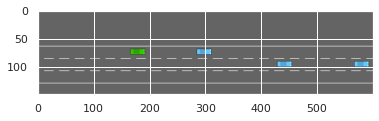

Ready to train <rl_agents.agents.deep_q_network.pytorch.DQNAgent object at 0x7f14883b1350> on <HighwayEnv<highway-v0>>


In [3]:
from rl_agents.trainer.evaluation import Evaluation
from rl_agents.agents.common.factory import load_agent, load_environment

# Get the environment and agent configurations from the rl-agents repository
!git clone https://github.com/lars-x/rl-agents.git
%cd /content/rl-agents/scripts/
env_config = 'configs/HighwayEnv/env.json'
agent_config = 'configs/HighwayEnv/agents/DQNAgent/dqn.json'

env = load_environment(env_config)
import pprint
from matplotlib import pyplot as plt
env.config["lane_change_reward"] = 0
env.config["vehicles_count"] = 10
# env.config['reward_speed_range'] = [0, 100]
env.config["lanes_count"] = 3
env.config["initial_lane_id"] = 0
pprint.pprint(env.config)
pprint.pprint(agent_config)

env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()

agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=250, display_env=False)
print(f"Ready to train {agent} on {env}")

Start training. Run tensorboard locally to visualize training.

In [4]:
# %tensorboard --logdir "{evaluation.directory}"
evaluation.train()

[INFO] Episode 0 score: 1.0 
[INFO] Episode 1 score: 1.7 
[INFO] Episode 2 score: 14.2 
[INFO] Episode 3 score: 5.0 
[INFO] Episode 4 score: 2.8 
[INFO] Episode 5 score: 8.1 
[INFO] Episode 6 score: 1.9 
[INFO] Episode 7 score: 16.0 
[INFO] Episode 8 score: 5.0 
[INFO] Episode 9 score: 1.2 
[INFO] Episode 10 score: 13.1 
[INFO] Episode 11 score: 4.6 
[INFO] Episode 12 score: 19.5 
[INFO] Episode 13 score: 5.8 
[INFO] Episode 14 score: 1.8 
[INFO] Episode 15 score: 1.8 
[INFO] Episode 16 score: 4.6 
[INFO] Episode 17 score: 3.7 
[INFO] Episode 18 score: 7.6 
[INFO] Episode 19 score: 15.9 
[INFO] Episode 20 score: 27.9 
[INFO] Episode 21 score: 4.7 
[INFO] Episode 22 score: 7.3 
[INFO] Episode 23 score: 2.5 
[INFO] Episode 24 score: 3.5 
[INFO] Episode 25 score: 30.1 
[INFO] Episode 26 score: 8.8 
[INFO] Episode 27 score: 16.1 
[INFO] Episode 28 score: 2.7 
[INFO] Episode 29 score: 32.9 
[INFO] Episode 30 score: 3.9 
[INFO] Episode 31 score: 6.2 
[INFO] Episode 32 score: 9.0 
[INFO] Epis

INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-140142_58')


Progress can be visualised in the tensorboard cell above, which should update every 30s (or manually). You may need to click the *Fit domain to data* buttons below each graph.

## Testing

Run the learned policy for a few episodes.

In [5]:
#env = load_environment(env_config)
env.configure({"offscreen_rendering": True})
agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=3, recover=True)
evaluation.test()
show_videos(evaluation.run_directory)

[INFO] Choosing GPU device: 0, memory used: 438 
[INFO] Loaded DQNAgent model from out/HighwayEnv/DQNAgent/saved_models/latest.tar 


INFO: Creating monitor directory out/HighwayEnv/DQNAgent/run_20210524-141007_58
INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-141007_58/openaigym.video.1.58.video000000.mp4


[INFO] Episode 0 score: 6.4 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-141007_58/openaigym.video.1.58.video000001.mp4


[INFO] Episode 1 score: 31.9 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-141007_58/openaigym.video.1.58.video000002.mp4


[INFO] Episode 2 score: 28.7 


INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-141007_58')


INFO: Making new env: highway-v0
{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'id': 'highway-v0',
 'import_module': 'highway_env',
 'initial_lane_id': 0,
 'lane_change_reward': -1,
 'lanes_count': 3,
 'manual_control': False,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 10,
 'vehicles_density': 1}
'configs/HighwayEnv/agents/DQNAgent/dqn.json'


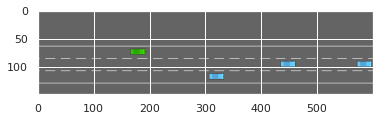

[INFO] Choosing GPU device: 0, memory used: 440 


INFO: Creating monitor directory out/HighwayEnv/DQNAgent/run_20210524-141415_58
Ready to train <rl_agents.agents.deep_q_network.pytorch.DQNAgent object at 0x7f1475654610> on <HighwayEnv<highway-v0>>


In [6]:
env = load_environment(env_config)
import pprint
from matplotlib import pyplot as plt
env.config["lane_change_reward"] = -1
env.config["vehicles_count"] = 10
# env.config['reward_speed_range'] = [0, 100]
env.config["lanes_count"] = 3
env.config["initial_lane_id"] = 0
pprint.pprint(env.config)
pprint.pprint(agent_config)

env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()

agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=250, display_env=False)
print(f"Ready to train {agent} on {env}")

In [7]:
# %tensorboard --logdir "{evaluation.directory}"
evaluation.train()

[INFO] Episode 0 score: 5.8 
[INFO] Episode 1 score: 19.2 
[INFO] Episode 2 score: 8.2 
[INFO] Episode 3 score: 6.2 
[INFO] Episode 4 score: 3.0 
[INFO] Episode 5 score: 6.0 
[INFO] Episode 6 score: 30.1 
[INFO] Episode 7 score: 6.4 
[INFO] Episode 8 score: 4.4 
[INFO] Episode 9 score: 7.0 
[INFO] Episode 10 score: 3.2 
[INFO] Episode 11 score: 3.3 
[INFO] Episode 12 score: 2.8 
[INFO] Episode 13 score: 12.5 
[INFO] Episode 14 score: 6.0 
[INFO] Episode 15 score: 9.6 
[INFO] Episode 16 score: 4.3 
[INFO] Episode 17 score: 29.4 
[INFO] Episode 18 score: 10.0 
[INFO] Episode 19 score: 8.1 
[INFO] Episode 20 score: 5.2 
[INFO] Episode 21 score: 29.1 
[INFO] Episode 22 score: 2.3 
[INFO] Episode 23 score: 2.7 
[INFO] Episode 24 score: 3.3 
[INFO] Episode 25 score: 6.5 
[INFO] Episode 26 score: 16.5 
[INFO] Episode 27 score: 4.6 
[INFO] Episode 28 score: 20.0 
[INFO] Episode 29 score: 1.7 
[INFO] Episode 30 score: 3.9 
[INFO] Episode 31 score: 10.9 
[INFO] Episode 32 score: 2.5 
[INFO] Epis

INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-141415_58')


In [8]:
env.configure({"offscreen_rendering": True})
agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=3, recover=True)
evaluation.test()
show_videos(evaluation.run_directory)

[INFO] Choosing GPU device: 0, memory used: 442 
[INFO] Loaded DQNAgent model from out/HighwayEnv/DQNAgent/saved_models/latest.tar 


INFO: Creating monitor directory out/HighwayEnv/DQNAgent/run_20210524-142257_58
INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-142257_58/openaigym.video.3.58.video000000.mp4


[INFO] Episode 0 score: 7.1 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-142257_58/openaigym.video.3.58.video000001.mp4


[INFO] Episode 1 score: 30.2 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-142257_58/openaigym.video.3.58.video000002.mp4


[INFO] Episode 2 score: 32.9 


INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210524-142257_58')
